# Assess model fits
Reviewer comment: "To substantiate the core claim, the authors need to provide considerably more details on the spectral fits, such as
1. plots of multiple example spectra with fits superimposed
2. distributions of fit r^2 statistics across electrodes, separately for baseline and encoding periods
3. distributions of number-of-peaks detected (which, I understand, is a free parameter), etc."
4. Additional r-squared plots for time-resolved and single-trial parameterization

## Set-up

### Imports

In [1]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from specparam import SpectralGroupModel

In [2]:
# custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from settings import COLORS
from specparam_utils import compute_adj_r2


### Settings

In [3]:
# set plotting style
plt.style.use('../mplstyle/default.mplstyle')

# set/create output path
dir_output = f"{PROJECT_PATH}/figures/reviewer_responses/model_fit"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)

# set figure size
FIG_SIZE = [3, 2]


## Main

### Import results
r-squared values and number-of-peaks detected for each condition

In [4]:
# Import r-squared values for each aperiodic model across all conditions

# init
df = pd.DataFrame(columns=['material','memory','window','chan_idx','r_squared','n_peaks'])

# loop through all conditions
for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:

                # load spectral parameters for condition and add to df
                params = SpectralGroupModel()
                params.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_knee')
                r_squared = compute_adj_r2(params)
                n_peaks = params.n_peaks_
                for chan_idx in range(len(params)):
                    row = pd.DataFrame([[material, memory, window, chan_idx, r_squared[chan_idx], n_peaks[chan_idx]]], 
                        columns=['material','memory','window','chan_idx','r_squared','n_peaks'])
                    df = pd.concat([df, row], ignore_index=True)
df[['r_squared','n_peaks']] = df[['r_squared','n_peaks']].apply(pd.to_numeric)
df

C:\Users\micha\AppData\Local\Temp\ipykernel_34276\3843572273.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], ignore_index=True)


,material,memory,window,chan_idx,r_squared,n_peaks
0,words,hit,pre,0,0.992538,1
1,words,hit,pre,1,0.991252,1
2,words,hit,pre,2,0.992428,2
3,words,hit,pre,3,0.991923,1
4,words,hit,pre,4,0.989169,0
...,...,...,...,...,...,...
5555,faces,miss,post,690,0.979073,0
5556,faces,miss,post,691,0.984815,0
5557,faces,miss,post,692,0.981885,2
5558,faces,miss,post,693,0.984669,1


### 1. Example spectral fits
plots of multiple example spectra with fits superimposed


Response: here we plot an example spectum with the fit superimposed for each experimental condition: memory condition (hit v. miss), material condition (words v. faces), and trial window (pre-stimulus v. post-stimulus).

In [7]:
dir(params)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_from_dict',
 '_ap_bounds',
 '_ap_fit',
 '_ap_guess',
 '_ap_percentile_thresh',
 '_bw_std_edge',
 '_calc_error',
 '_calc_r_squared',
 '_cf_bound',
 '_check_data',
 '_check_freqs',
 '_check_loaded_results',
 '_check_loaded_settings',
 '_check_width_limits',
 '_create_peak_params',
 '_debug',
 '_drop_peak_cf',
 '_drop_peak_overlap',
 '_error_metric',
 '_fit',
 '_fit_peak_guess',
 '_fit_peaks',
 '_gauss_overlap_thresh',
 '_gauss_std_limits',
 '_get_results',
 '_maxfev',
 '_peak_fit',
 '_prepare_data',
 '_regenerate_freqs',
 '_regenerate_model',
 '_reset_data_resu

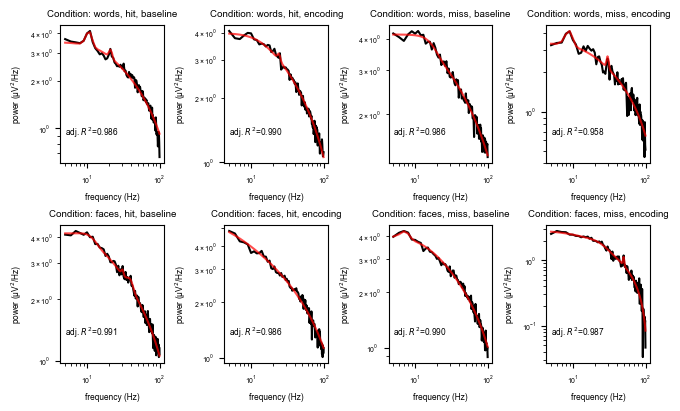

In [19]:
# plot spectral model fit for a random channel for eah condition


# create figure
fig, axes = plt.subplots(2,4, figsize=[6.5, 4], constrained_layout=True)
ii = 0

# loop through all conditions 
for material in ['words','faces']:
    for memory in ['hit','miss']:
        for window in ['pre', 'post']:

                # load spectral parameters for condition
                params = SpectralGroupModel()
                params.load(f'{PROJECT_PATH}/data/ieeg_psd_param/psd_{material}_{memory}_{window}stim_params_knee')

                # get model for random condition and compute adjusted r-squared
                while True:
                    chan_idx = np.random.randint(len(params))
                    try:
                        model = params.get_model(chan_idx)
                        break
                    except:
                        continue
                     
                r_squared = compute_adj_r2(params)[chan_idx]

                # plot model fit
                ax = np.ravel(axes)[ii]
                ax.plot(model.freqs, model.power_spectrum, color='k')
                ax.plot(model.freqs, model.get_model('full'), color='r', alpha=0.7)
                ax.set_xscale('log')
                ax.set_yscale('log')

                # label
                if window == 'pre':
                    win = 'baseline'
                elif window == 'post':
                    win = 'encoding'
                ax.set_title(f"Condition: {material}, {memory}, {win}")
                ax.set(xlabel='frequency (Hz)', ylabel='power (\u03BCV$^2$/Hz)')
                ax.text(0.3, 0.2, f"adj. $R^2$={r_squared:.3f}", 
                        transform=ax.transAxes, ha='center')

                ii += 1

# save
plt.savefig(f"{dir_output}/example_fits.png")

### 2. Distribution of r-squared 
distributions of fit r^2 statistics across electrodes, separately for baseline and encoding periods


Response: The mean r-squared value across all spectra fit was 0.976. R-squared values were similar across all conditions.

In [34]:
# bin edge for r-squared histograms
bin_edges = np.linspace(0, 1, 81)

#### trial-average spectra

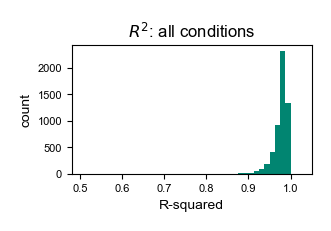

Mean R-squared: 	0.9758981866793482


In [36]:
# plot histogram of r-squared values (all conditions combined)
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(df['r_squared'], bins=bin_edges, color=COLORS['blue'])
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$: all conditions")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
plt.savefig(f"{dir_output}/r2_all_channels.png")
plt.show()

print(f"Mean R-squared: \t{np.nanmean(df['r_squared'])}")

Mean R-squared baseline: 	0.9761643030831847
Mean R-squared encoding: 	0.9756319708670685


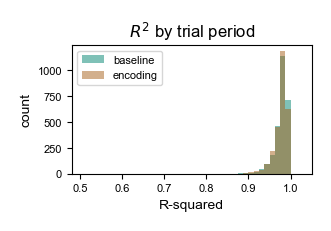

In [37]:
# plot histogram of r-squared values (baseline v. encoding)

# compute mean for each condition
r2_0 = df.loc[df['window']=='pre', 'r_squared'].values
r2_1 = df.loc[df['window']=='post', 'r_squared'].values
print(f"Mean R-squared baseline: \t{np.nanmean(r2_0)}")
print(f"Mean R-squared encoding: \t{np.nanmean(r2_1)}")

# plot histogram
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
# ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=COLORS['blue'], label=f'baseline: mean={np.nanmean(r2_0):.4f}')
# ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=COLORS['brown'], label=f'encoding: mean={np.nanmean(r2_1):.4f}')
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=COLORS['blue'], label='baseline')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=COLORS['brown'], label='encoding')
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$ by trial period")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend(fontsize=8)

# save/show
plt.savefig(f"{dir_output}/r2_pre_v_post.png")
plt.show()

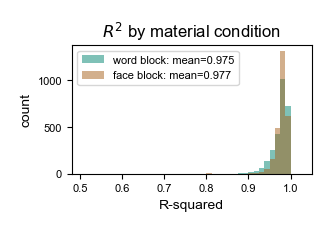

In [38]:
# plot histogram of r-squared values (word v. face)

# compute mean for each condition
r2_0 = df.loc[df['material']=='words', 'r_squared'].values
r2_1 = df.loc[df['material']=='faces', 'r_squared'].values

# plot histogram
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=COLORS['blue'], label=f'word block: mean={np.nanmean(r2_0):.3f}')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=COLORS['brown'], label=f'face block: mean={np.nanmean(r2_1):.3f}')
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$ by material condition")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend(fontsize=8)
plt.show()

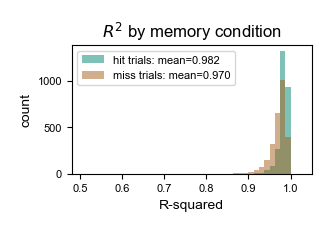

In [39]:
# plot histogram of r-squared values (hit v. miss)

# compute mean for each condition
r2_0 = df.loc[df['memory']=='hit', 'r_squared'].values
r2_1 = df.loc[df['memory']=='miss', 'r_squared'].values

# plot histogram
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(r2_0, bins=bin_edges, alpha=0.5, color=COLORS['blue'], 
        label=f'hit trials: mean={np.nanmean(r2_0):.3f}')
ax.hist(r2_1, bins=bin_edges, alpha=0.5, color=COLORS['brown'], 
        label=f'miss trials: mean={np.nanmean(r2_1):.3f}')
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$ by memory condition")
ax.set_xlim([np.min(df['r_squared'])-0.05, 1.05])
ax.legend(fontsize=8)
plt.show()

### 3. Distribution of number-of-peaks detected
distributions of number-of-peaks detected (which, I understand, is a free parameter), etc. 

Response: The maximum number of peaks in the model is a free parameter of the spectral parameterization method. For all analyses in this manuscript, the 'max_n_peaks' argument was set to 4. If the number of peaks is not limited, the fitting algorithm may overfit the data (reducing error in the model by fitting Gaussians to noise in the spectrum). In this dataset, given the other parameters (peak threshold = 3 standard deviations), the maximum (4 peaks) was only detected for 1.4% of spectra fit. Most commonly (43%) a single peak was detected, and often (22%) no peaks met the threshold criteria.

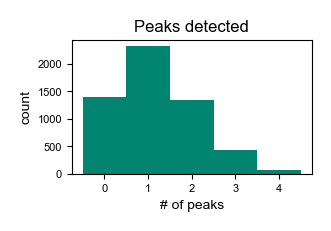

1 peaks: 2320 (41.73%)
0 peaks: 1401 (25.20%)
2 peaks: 1333 (23.97%)
3 peaks: 434 (7.81%)
4 peaks: 72 (1.29%)


In [26]:
# plot histogram of r-squared values (all conditions combined)

# plot
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
bin_edges_ = np.linspace(0,5,6)-0.5
ax.hist(df['n_peaks'], bins=bin_edges_, color=COLORS['blue'])
ax.set(xlabel="# of peaks", ylabel="count")
ax.set_title("Peaks detected")
ax.set_xticks(bin_edges_[:-1]+0.5)

# save/show
plt.savefig(f"{dir_output}/n_peaks_detected.png")
plt.show()

# print counts / percentage
percentages = df['n_peaks'].value_counts()/len(df)*100
for n_peaks, count in df['n_peaks'].value_counts().items():
    print(f"{n_peaks} peaks: {count} ({percentages[n_peaks]:.2f}%)")

### 4. Additional r-squared plots for time-resolved and single-trial parameterization

#### time-resolved spectral parameterization

In [11]:
# get channel info for task-modulated channels

# load channel info
chan_info = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)

# load task-modulation results
results = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv", index_col=0)
df_tr = chan_info.loc[results['sig_all']].reset_index(drop=True)
df_tr

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,100,pat04,0,A01-A09,-58.30120,52.43075,-26.23685
1,105,pat04,5,A10-A18,-48.67445,61.57940,-21.63940
2,106,pat04,6,A11-A19,-45.27960,64.12270,-9.09570
3,109,pat04,9,A18-A26,-37.41585,63.49935,-23.07515
4,110,pat04,10,A19-A27,-34.53655,66.37405,-11.72635
...,...,...,...,...,...,...,...
56,1346,pat22,9,IFG_05-IFG_06,23.00000,-51.00000,6.00000
57,1347,pat22,10,IFG_06-IFG_07,24.00000,-55.00000,5.50000
58,1348,pat22,11,IFG_07-IFG_08,25.00000,-58.00000,4.50000
59,1361,pat22,24,PI_04-PI_05,-10.00000,-40.00000,25.50000


In [12]:
# load specparam results for each channel and compute adjusted r-squared

path_in = f"{PROJECT_PATH}/data/ieeg_tfr_param"
r2_list = []
for material in ['words', 'faces']:
    for memory in ['hit', 'miss']:
        for i_row, row in df_tr.iterrows():
            fname = f"{row['patient']}_{material}_{memory}_chan{row['chan_idx']}_tfr_param_knee"
            sgm = SpectralGroupModel()
            sgm.load(f"{path_in}/{fname}")
            r2 = compute_adj_r2(sgm)
            r2_list.append(r2)

# combine results
r_squared = np.concatenate(r2_list)
print(r_squared.shape)


(55632,)


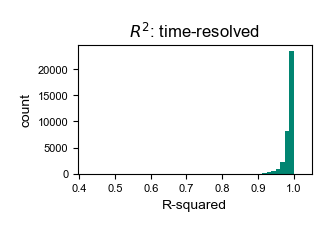

Mean R-squared: 	0.9815709726228944


In [40]:
# plot histogram of r-squared values
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(r_squared, bins=bin_edges, color=COLORS['blue'])
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$: time-resolved")
ax.set_xlim([np.nanmin(r_squared)-0.05, 1.05])
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# save/show
plt.savefig(f"{dir_output}/r2_time_resolved.png")
plt.show()

# print mean r-squared
print(f"Mean R-squared: \t{np.nanmean(r_squared)}")

#### single-trial spectra

In [ ]:
# bin edge for r-squared histograms
bin_edges = np.linspace(0, 1, 41)

In [14]:
# load params
df_st = pd.read_csv(f"{PROJECT_PATH}/data/results/psd_trial_params.csv")
df_st

,patient,trial,chan_idx,material,memory,epoch,ap_mode,offset,exponent,error,r_squared,r2_adj,alpha,alpha_adj,gamma,gamma_adj,knee
0,pat02,0,0,faces,hit,post,fixed,6.675666,2.521925,0.408902,0.701993,0.685437,3.784398,4.416340,2.128099,1.854503,NaN
1,pat02,0,1,faces,hit,post,fixed,5.855543,2.131122,0.407990,0.637631,0.629838,3.458305,3.782459,1.916144,1.746649,NaN
2,pat02,0,2,faces,hit,post,fixed,5.872600,1.971668,0.416719,0.581182,0.572175,3.711390,3.955754,2.276487,2.178522,NaN
3,pat02,0,3,faces,hit,post,fixed,5.810196,1.824834,0.392473,0.550786,0.541125,3.712280,4.576300,2.486117,2.324858,NaN
4,pat02,0,4,faces,hit,post,fixed,6.205565,2.189813,0.407078,0.655923,0.648524,4.055515,3.903695,2.186920,2.265435,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551603,pat22,41,48,words,miss,pre,knee,5.063870,2.798752,0.446397,0.677268,0.666744,2.317263,2.633392,-0.084054,-0.082436,97.676670
551604,pat22,41,49,words,miss,pre,knee,6.681917,3.230717,0.429152,0.764901,0.757235,3.439539,3.100281,0.789845,0.865534,1158.789174
551605,pat22,41,50,words,miss,pre,knee,7.805069,3.868256,0.473975,0.698820,0.688999,3.240394,3.556844,0.712896,0.721468,38526.782843
551606,pat22,41,51,words,miss,pre,knee,7.148680,3.062980,0.375531,0.802541,0.796103,4.221706,3.953806,1.654864,1.541866,127.824841


Mean R-squared fixed: 	0.646157922078337
Mean R-squared knee: 	0.6654328361260057


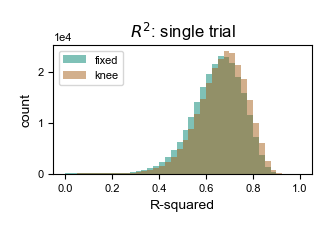

In [28]:
# plot hist of r-squared values for both ap_modes

# get mean r-squared values for each mode
mean_fixed = df_st.loc[df_st['ap_mode']=='fixed', 'r2_adj'].mean()
mean_knee = df_st.loc[df_st['ap_mode']=='knee', 'r2_adj'].mean()
print(f"Mean R-squared fixed: \t{mean_fixed}")
print(f"Mean R-squared knee: \t{mean_knee}")

# plot
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(df_st.loc[df_st['ap_mode']=='fixed', 'r2_adj'], bin_edges, alpha=0.5, 
    label='fixed', color=COLORS['blue'])
ax.hist(df_st.loc[df_st['ap_mode']=='knee', 'r2_adj'], bin_edges, alpha=0.5,
    label='knee', color=COLORS['brown'])
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$: single trial")
ax.legend(fontsize=8)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()



Mean R-squared pre: 	0.6583911887462727
Mean R-squared post: 	0.653199145182143


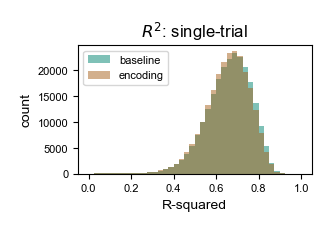

In [29]:
# plot hist of r-squared values for pre and post

# get mean r-squared values for each epoch
mean_pre = np.nanmean(df_st.loc[df_st["epoch"]=="pre", "r2_adj"])
mean_post = np.nanmean(df_st.loc[df_st["epoch"]=="post", "r2_adj"])
print(f"Mean R-squared pre: \t{mean_pre}")
print(f"Mean R-squared post: \t{mean_post}")

# plot
fig, ax = plt.subplots(1,1, figsize=FIG_SIZE)
ax.hist(df_st.loc[df_st['epoch']=='pre', 'r2_adj'], bin_edges, alpha=0.5, 
        color=COLORS['blue'], label='baseline')
ax.hist(df_st.loc[df_st['epoch']=='post', 'r2_adj'], bin_edges, alpha=0.5, 
        color=COLORS['brown'], label='encoding')
ax.set(xlabel="R-squared", ylabel="count")
ax.set_title("$R^2$: single-trial")
ax.legend(fontsize=8)

# save/show
plt.savefig(f"{dir_output}/r2_single_trial.png")
plt.show()

In [17]:
# print mean r-squared
print(f"Mean adjusted R-squared (fixed): {df_st.loc[df_st['ap_mode']=='fixed', 'r2_adj'].mean():.3f}")
print(f"Mean adjusted R-squared (knee): {df_st.loc[df_st['ap_mode']=='knee', 'r2_adj'].mean():.3f}")
print(f"\nMean adjusted R-squared (pre): {df_st.loc[df_st['epoch']=='pre', 'r2_adj'].mean():.3f}")
print(f"Mean adjusted R-squared (post): {df_st.loc[df_st['epoch']=='post', 'r2_adj'].mean():.3f}")

Mean adjusted R-squared (fixed): 0.646
Mean adjusted R-squared (knee): 0.665

Mean adjusted R-squared (pre): 0.658
Mean adjusted R-squared (post): 0.653


As expected, r-squared values are lower for the single spectra than trial-average spectra; however, the model still captures most of the variance in the data. Crucially, the r-squared values are comparaed between the baseline and encoding periods.